In [1]:
import os 

os.chdir('../..')

In [2]:
import scipy
import numpy as np
from collections import Counter
import multiprocessing
import pywt
from tqdm import tqdm

In [3]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossing_indices = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) < np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossing_indices, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def psy_features(channel):
    dic = pys.electrocardiography.analyzeECG(channel, samplerate=100, pnn50pnn20=False, freqAnalysis=False,
                                             freqAnalysisFiltered=False)
    ibi = [dic['ibi']/100]
    val_names = ['bpm', 'sdnn', 'sdsd', 'rmssd', 'pnn50', 'pnn20']
    vals = [dic[val] for val in val_names]
    pnn50pnn20 = [0 if vals[-1]==0 else vals[-2]/vals[-1]]
    return ibi + vals + pnn50pnn20
        

def get_single_ecg_features(signal, waveletname='db6'):
    features = []
    for channel in signal.T:
        list_coeff = pywt.wavedec(channel, wavelet=waveletname, level=5)
        channel_features = []
        for coeff in list_coeff:
            channel_features += get_features(coeff)
        
        channel_features += psy_features(channel)
        
        features.append(channel_features)
    return np.array(features).flatten()

def get_ecg_features(ecg_data, parallel=False):
    if parallel:
        pool = multiprocessing.Pool(4)
        return np.array(pool.map(get_single_ecg_features, ecg_data))
    else:
        list_features = []
        for signal in tqdm(ecg_data):
            features = get_single_ecg_features(signal)
            list_features.append(features)
        return np.array(list_features)

In [4]:
import pysiology as pys
import utils

Thank you for using Pysiology. If you use it in your work, please cite:
Gabrieli G., Azhari A., Esposito G. (2020) PySiology: A Python Package for Physiological Feature Extraction. In: Esposito A., Faundez-Zanuy M., Morabito F., Pasero E. (eds) Neural Approaches to Dynamics of Signal Exchanges. Smart Innovation, Systems and Technologies, vol 151. Springer, Singapore. https://doi.org/10.1007/978-981-13-8950-4_35


In [5]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'priority'
experiment_name = 'exp4'

data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [6]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

X_train = X_train[:,:,0].reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test[:,:,0].reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val[:,:,0].reshape(X_val.shape[0], X_val.shape[1], 1)

This experiment has 43 classes


In [51]:
XF_train = get_ecg_features(X_train)

100%|██████████| 17080/17080 [01:44<00:00, 163.15it/s]


In [43]:
XF_train[0]

array([ 3.71357207e+00,  1.30000000e+01,  9.00000000e+00, -6.03531111e-01,
       -5.73527277e-01,  2.24004232e-01,  4.00229615e-01, -1.10013840e-01,
       -1.15924727e-01,  3.93535633e-01,  1.54870294e-01,  3.46845658e-01,
        3.71357207e+00,  1.20000000e+01,  1.20000000e+01, -2.46462031e-01,
       -3.11317346e-02,  1.79595952e-01,  2.79842904e-01,  6.04318114e-02,
        5.14416161e-02,  1.56810157e-01,  2.45894255e-02,  1.33359756e-01,
        4.27666612e+00,  4.40000000e+01,  4.30000000e+01, -2.64694871e-01,
       -8.56663587e-02,  1.37670899e-01,  2.31653357e-01,  2.70298321e-02,
        2.27047869e-02,  1.46659067e-01,  2.15088819e-02,  1.21244955e-01,
        4.89783980e+00,  8.60000000e+01,  9.00000000e+01, -1.49963068e-01,
       -4.87245585e-02,  4.36759208e-02,  3.10176558e-01, -6.10177655e-04,
        1.09226504e-02,  1.48331075e-01,  2.20021078e-02,  8.59886443e-02,
        5.55295958e+00,  1.64000000e+02,  1.66000000e+02, -9.92379800e-02,
       -2.13468342e-02,  

In [7]:
def get_single_ecg_feature(signal, waveletname='db6'):
    features = []
    for channel in signal.T:
        list_coeff = pywt.wavedec(channel, wavelet=waveletname, level=5)
        channel_features = []
        for coeff in list_coeff:
            channel_features += get_features(coeff)
        
        channel_features += psy_features(channel)
        
        features.append(channel_features)
    return np.array(features).flatten()

c:\Users\agarw\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


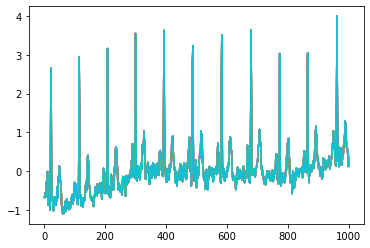

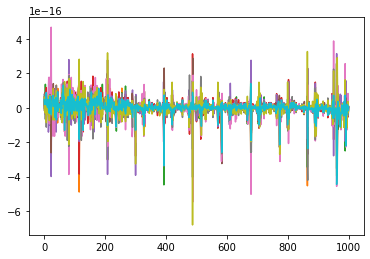

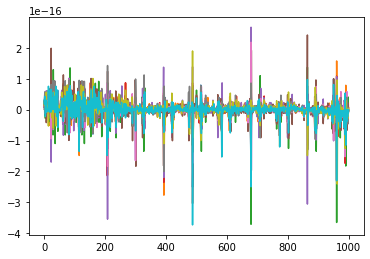

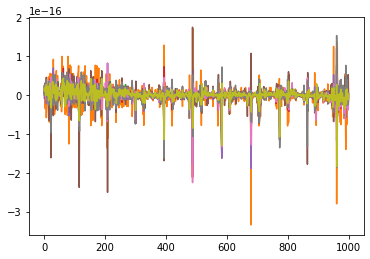

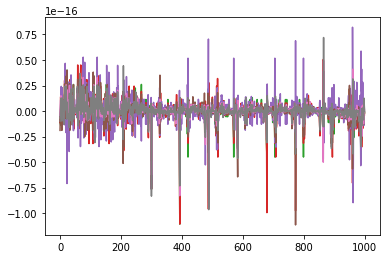

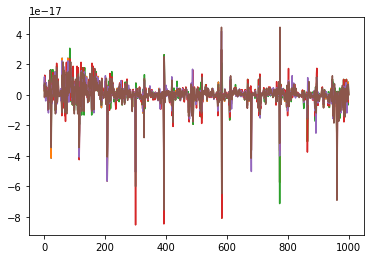

In [13]:
import matplotlib.pyplot as plt
vals = pywt.wavedec(X_train[0], wavelet='db6', level=5)

for val in vals:
    plt.plot(val)
    plt.show()